In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import pickle

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.model_selection import ShuffleSplit
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import scale

# import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
# set_session(tf.Session(config=config))

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, GaussianNoise, Conv1D , GRU
from tensorflow.keras.layers import Dropout, Concatenate, Flatten, Activation, TimeDistributed, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Input, Dense, LSTM, multiply, concatenate, Activation, Masking, add
from tensorflow.keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout
from tensorflow.python.keras.utils import plot_model
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

def MAE(y_te, pred):
    return np.round(mean_absolute_error(y_te, pred), decimals=4)
    
def RMSE(y_te, pred):
    return np.round(mean_squared_error(y_te, pred)**(1/2), decimals=4)
    
def ME(y_te, pred):
    return np.round((y_te-pred).mean(), decimals=4)

def evaluate(y_te, pred):
    print("mae: {:.4f}".format(mean_absolute_error(y_te, pred)))
    print("rmse: {:.4f}".format(mean_squared_error(y_te, pred)**(1/2)))
    print("me: {:.4f}".format((y_te-pred).mean()))

seed = 0

In [2]:
target_var = ['Target_Hb']

info_vars = ['Study_Subject_Number', 'Order']

categoryA = ["Hemoglobin[Whole blood]", "Delta_Hb", "RDW[Whole blood]", "MCV[Whole blood]", "MCH[Whole blood]", "MCHC[Whole blood]", "Serum Iron[Serum]", "Age (yrs)", "Sex_M", "Sex_F", 'EPO_Dose']

categoryB = ["URR[Serum]", 'Dry Weight', 'Albumin[Serum]', 'Predialysis Weight', 'Height (cm)']

trn_vars = categoryA + categoryB

all_vars = info_vars + trn_vars + target_var

In [3]:
with open('./scaler/trn_scaler_mean.pkl','rb') as f:
    trn_scaler_mean = pickle.load(f)
    
with open('./scaler/hb_scaler_mean.pkl','rb') as f:
    hb_scaler_mean = pickle.load(f)

In [4]:
df = pd.read_excel("data_processed.xlsx", sheet_name=0, header=0)

indexes = np.unique(df['Study_Subject_Number'].values, return_index=True)[1]
patient_list = [df['Study_Subject_Number'].values[index] for index in sorted(indexes)]

# GRU with Attention

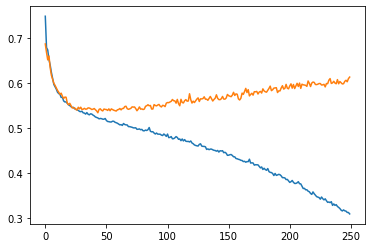

6
train
mae: 0.5647
rmse: 0.7407
me: -0.0014
val
mae: 0.5803
rmse: 0.7564
me: 0.0016
test
mae: 0.5980
rmse: 0.7827
me: 0.0196




In [30]:
seq_len = 6

learning_rate = 0.001
epochs = 250
batch_size = 2048 
seed = 0
sequences = [2,3,4,5,6]
def softmax_period(x):
    return K.softmax(x, axis=1)

def get_model():
    K.clear_session()
    np.random.seed(seed)
    inp = Input(shape=(seq_len, len(trn_vars)), name='Input')
#     gauss1 = GaussianNoise(0.1)(inp)
    
    attention_input_ = Dense(256, activation = 'relu', name='attention_1')(inp)
#     attention_probs_ = TimeDistributed(Dense(len(trn_vars), activation='sigmoid'), name='attention_weight_')(attention_input_)
    attention_probs_ = Dense(len(trn_vars), activation='sigmoid', name='attention_weight_')(attention_input_)
    attended_inp = multiply([inp, attention_probs_], name='attention_mul_') 
    
    dim = 256
    layer1 = GRU(dim, return_sequences=True,
                recurrent_activation='hard_sigmoid',
                activation='tanh', name='GRU_1')(attended_inp)

#     attention_input = Dense(256, activation = 'tanh', name='attention_inp')(layer1)
#     attention_probs = Dense(1, activation=softmax_period, name='attention_weight')(attention_input)
#     attention_layer = Lambda(lambda x: K.repeat_elements(x, dim, axis=2), name='attention_output')(attention_probs)
    
#     attention_mul = multiply([layer1, attention_layer], name='attention_mul')
    layer2 = GRU(64, return_sequences=False,
                recurrent_activation='hard_sigmoid',
                activation='tanh', name='GRU_2')(layer1)
    fc = Dense(4, name='Dense_1')(layer2)
    outp = Dense(1, name='Output')(fc)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss = 'mean_absolute_error', 
                  optimizer=Adam(learning_rate),
                  metrics=['mean_absolute_error'])

    return model

# for s in tqdm(sequences) :
#     seq_len = s
    
with open('./data/mean_{}.pkl'.format(seq_len),'rb') as f:
    loaded_data = pickle.load(f)
[[x_train,y_train,_],[x_valid,y_valid,_],[x_test,y_test,_]] = loaded_data

model = get_model()

checkpoint = ModelCheckpoint('./model/gru_mean_attn_temp{}.h5'.format(seq_len), save_best_only=True, verbose=0)

hist = model.fit(x_train, y_train, 
                 callbacks=[checkpoint],
                 validation_data=(np.array(x_valid), np.array(y_valid)), 
                 batch_size=batch_size, epochs=epochs, verbose=0)

plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.show()

model.load_weights('./model/gru_mean_attn_temp{}.h5'.format(seq_len))

print(seq_len)
pred_train = model.predict(x_train)
print('train')
y_train = hb_scaler_mean.inverse_transform(y_train)
pred_train = hb_scaler_mean.inverse_transform(pred_train)
evaluate(y_train, pred_train)

pred_valid = model.predict(x_valid)
print('val')
y_valid = hb_scaler_mean.inverse_transform(y_valid)
pred_valid = hb_scaler_mean.inverse_transform(pred_valid)
evaluate(y_valid, pred_valid)

pred_test = model.predict(x_test)
print('test')
y_test = hb_scaler_mean.inverse_transform(y_test)
pred_test = hb_scaler_mean.inverse_transform(pred_test)
evaluate(y_test, pred_test)

print()
print()

In [33]:
# test
# mae: 0.5939
# rmse: 0.7754
# me: -0.0041

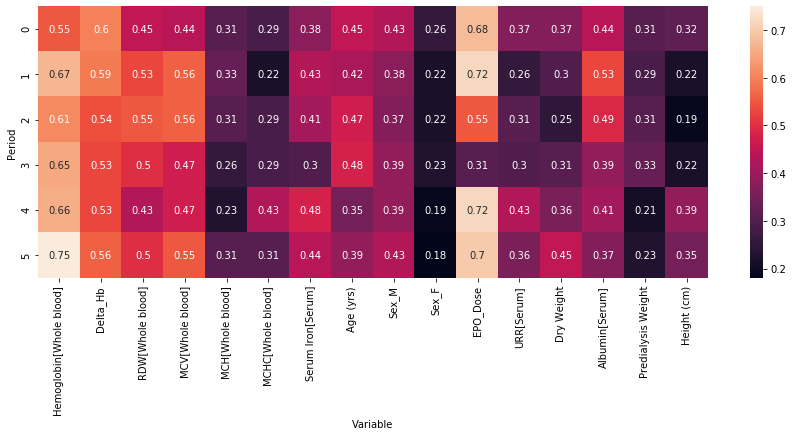

In [36]:
attention_model = Model(inputs=model.input, outputs=model.get_layer('attention_weight_').output)   
attn1 = attention_model.predict(x_train)

import seaborn as sns
plt.figure(figsize=(15,5))
sns.heatmap((attn1[0]).round(2), annot=True)
plt.xticks(np.array(range(len(trn_vars)))+0.5, trn_vars, rotation=90)
plt.xlabel('Variable')
plt.ylabel('Period') 
plt.show()

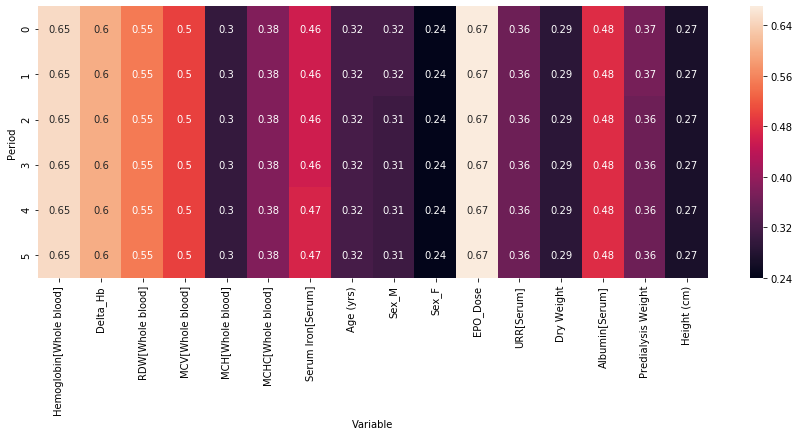

In [34]:
attention_model = Model(inputs=model.input, outputs=model.get_layer('attention_weight_').output)   
attn1 = attention_model.predict(x_train)

import seaborn as sns
plt.figure(figsize=(15,5))
sns.heatmap((np.mean(attn1, axis=0)).round(2), annot=True)
plt.xticks(np.array(range(len(trn_vars)))+0.5, trn_vars, rotation=90)
plt.xlabel('Variable')
plt.ylabel('Period') 
plt.show()

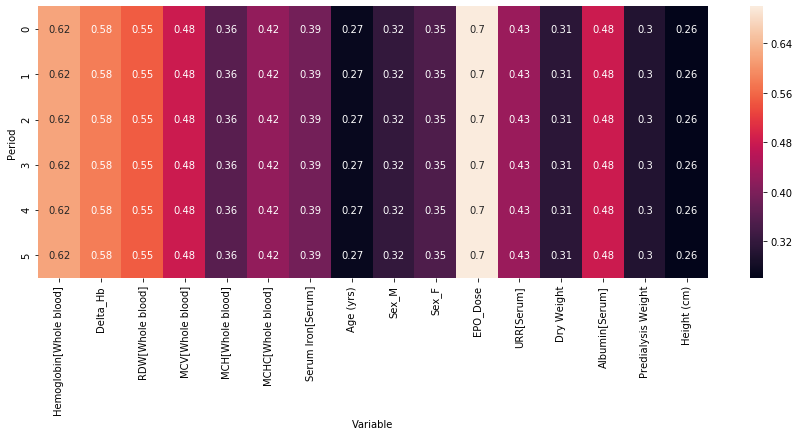

In [11]:
attention_model = Model(inputs=model.input, outputs=model.get_layer('attention_weight_').output)   
attn1 = attention_model.predict(x_train)

import seaborn as sns
plt.figure(figsize=(15,5))
sns.heatmap((np.mean(attn1, axis=0)).round(2), annot=True)
plt.xticks(np.array(range(len(trn_vars)))+0.5, trn_vars, rotation=90)
plt.xlabel('Variable')
plt.ylabel('Period')
plt.show()

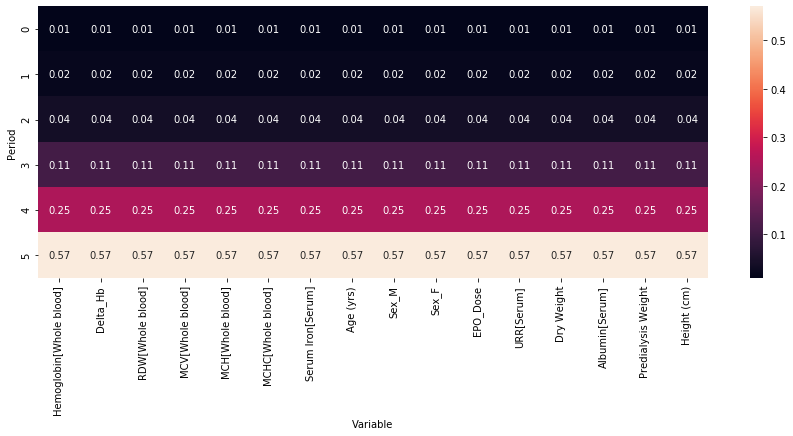

In [6]:
attention_model = Model(inputs=model.input, outputs=model.get_layer('attention_weight').output)   
attn2 = attention_model.predict(x_train)

import seaborn as sns
plt.figure(figsize=(15,5))
sns.heatmap((np.mean(np.repeat(attn2, repeats=len(trn_vars), axis=2), axis=0)).round(2), annot=True)
plt.xticks(np.array(range(len(trn_vars)))+0.5, trn_vars, rotation=90)
plt.xlabel('Variable')
plt.ylabel('Period')
plt.show()

# GRU with Attention (Saved)

W0731 05:25:40.928727 21012 deprecation.py:323] From C:\Users\A\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


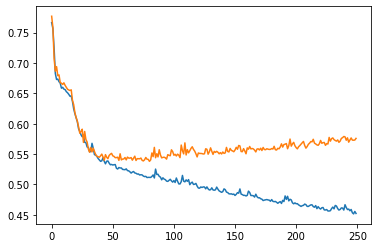

6
train
mae: 0.5544
rmse: 0.7329
me: 0.0318
val
mae: 0.5845
rmse: 0.7601
me: 0.0470
test
mae: 0.6151
rmse: 0.8058
me: 0.0847




In [7]:
seq_len = 6

learning_rate = 0.001
epochs = 250
batch_size = 2048 
seed = 0
sequences = [2,3,4,5,6]
def softmax_period(x):
    return K.softmax(x, axis=1)

def get_model():
    K.clear_session()
    np.random.seed(seed)
    inp = Input(shape=(seq_len, len(trn_vars)), name='Input')
#     gauss1 = GaussianNoise(0.1)(inp)
    
    attention_input_ = Dense(256, activation = 'relu', name='attention_1')(inp)
    attention_probs_ = TimeDistributed(Dense(len(trn_vars), activation='softmax'), name='attention_weight_')(attention_input_)
    attended_inp = multiply([inp, attention_probs_], name='attention_mul_') 
    
    dim = 256
    layer1 = GRU(dim, return_sequences=True,
                recurrent_activation='hard_sigmoid',
                activation='tanh', name='GRU_1')(attended_inp)

    attention_input = Dense(256, activation = 'tanh', name='attention_inp')(layer1)
    attention_probs = Dense(1, activation=softmax_period, name='attention_weight')(attention_input)
    attention_layer = Lambda(lambda x: K.repeat_elements(x, dim, axis=2), name='attention_output')(attention_probs)
    
    attention_mul = multiply([layer1, attention_layer], name='attention_mul')
    layer2 = GRU(64, return_sequences=False,
                recurrent_activation='hard_sigmoid',
                activation='tanh', name='GRU_2')(attention_mul)
    fc = Dense(4, name='Dense_1')(layer2)
    outp = Dense(1, name='Output')(fc)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss = 'mean_absolute_error', 
                  optimizer=Adam(learning_rate),
                  metrics=['mean_absolute_error'])

    return model

# for s in tqdm(sequences) :
#     seq_len = s
    
with open('./data/mean_{}.pkl'.format(seq_len),'rb') as f:
    loaded_data = pickle.load(f)
[[x_train,y_train,_],[x_valid,y_valid,_],[x_test,y_test,_]] = loaded_data

model = get_model()

checkpoint = ModelCheckpoint('./model/gru_mean_attn{}.h5'.format(seq_len), save_best_only=True, verbose=0)

hist = model.fit(x_train, y_train, 
                 callbacks=[checkpoint],
                 validation_data=(np.array(x_valid), np.array(y_valid)), 
                 batch_size=batch_size, epochs=epochs, verbose=0)

plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.show()

model.load_weights('./model/gru_mean_attn{}.h5'.format(seq_len))

print(seq_len)
pred_train = model.predict(x_train)
print('train')
y_train = hb_scaler_mean.inverse_transform(y_train)
pred_train = hb_scaler_mean.inverse_transform(pred_train)
evaluate(y_train, pred_train)

pred_valid = model.predict(x_valid)
print('val')
y_valid = hb_scaler_mean.inverse_transform(y_valid)
pred_valid = hb_scaler_mean.inverse_transform(pred_valid)
evaluate(y_valid, pred_valid)

pred_test = model.predict(x_test)
print('test')
y_test = hb_scaler_mean.inverse_transform(y_test)
pred_test = hb_scaler_mean.inverse_transform(pred_test)
evaluate(y_test, pred_test)

print()
print()

In [8]:
# train
# mae: 0.5642
# rmse: 0.7418
# me: -0.0139
# val
# mae: 0.5885
# rmse: 0.7684
# me: -0.0194
# test
# mae: 0.6110
# rmse: 0.8013
# me: 0.0013

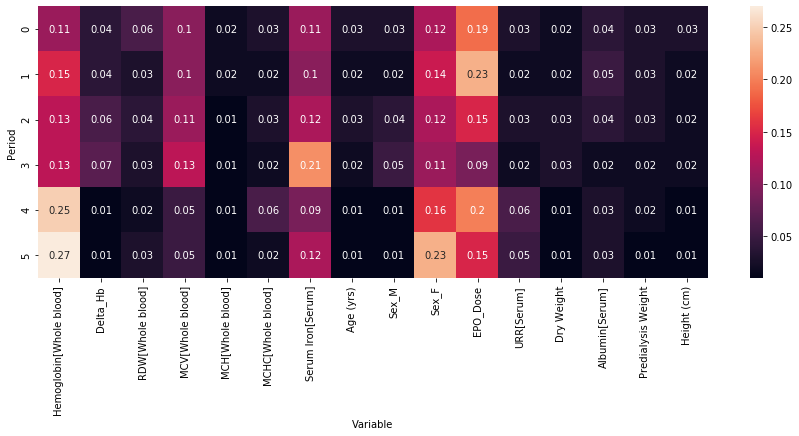

In [16]:
attention_model = Model(inputs=model.input, outputs=model.get_layer('attention_weight_').output)   
attn1 = attention_model.predict(x_train)

import seaborn as sns
plt.figure(figsize=(15,5))
sns.heatmap(attn1[0].round(2), annot=True)
plt.xticks(np.array(range(len(trn_vars)))+0.5, trn_vars, rotation=90)
plt.xlabel('Variable')
plt.ylabel('Period')
plt.show()

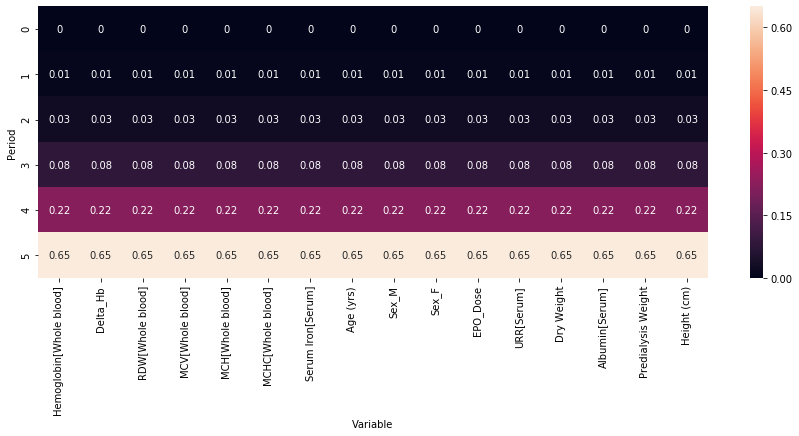

In [18]:
attention_model = Model(inputs=model.input, outputs=model.get_layer('attention_weight').output)   
attn2 = attention_model.predict(x_train)

import seaborn as sns
plt.figure(figsize=(15,5))
sns.heatmap((np.repeat(attn2[0], repeats=len(trn_vars), axis=1)).round(2), annot=True)
plt.xticks(np.array(range(len(trn_vars)))+0.5, trn_vars, rotation=90)
plt.xlabel('Variable')
plt.ylabel('Period')
plt.show()

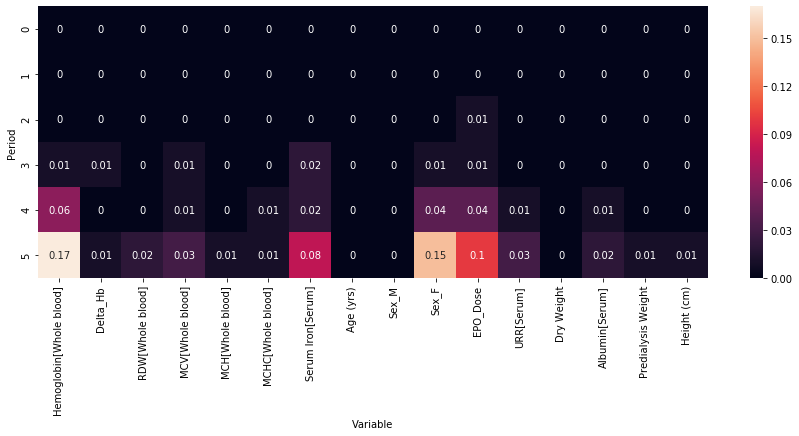

In [20]:
import seaborn as sns
plt.figure(figsize=(15,5))
sns.heatmap((attn1[0]*np.repeat(attn2[0], repeats=len(trn_vars), axis=1)).round(2), annot=True)
plt.xticks(np.array(range(len(trn_vars)))+0.5, trn_vars, rotation=90)
plt.xlabel('Variable')
plt.ylabel('Period')
plt.show()

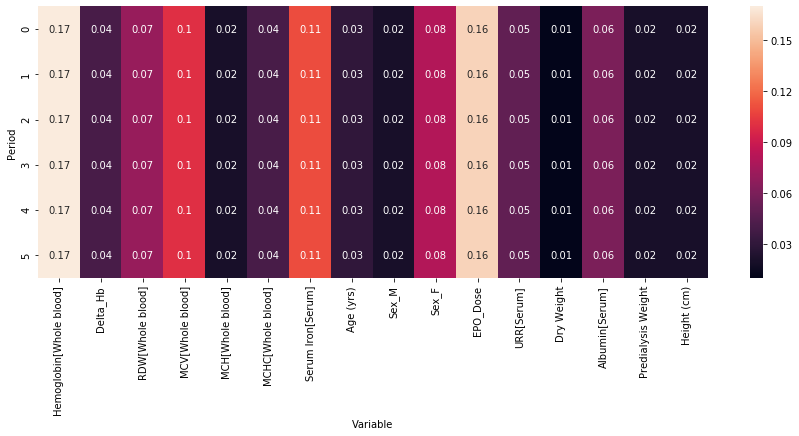

In [21]:
attention_model = Model(inputs=model.input, outputs=model.get_layer('attention_weight_').output)   
attn1 = attention_model.predict(x_train)

import seaborn as sns
plt.figure(figsize=(15,5))
sns.heatmap((np.mean(attn1, axis=0)).round(2), annot=True)
plt.xticks(np.array(range(len(trn_vars)))+0.5, trn_vars, rotation=90)
plt.xlabel('Variable')
plt.ylabel('Period')
plt.show()

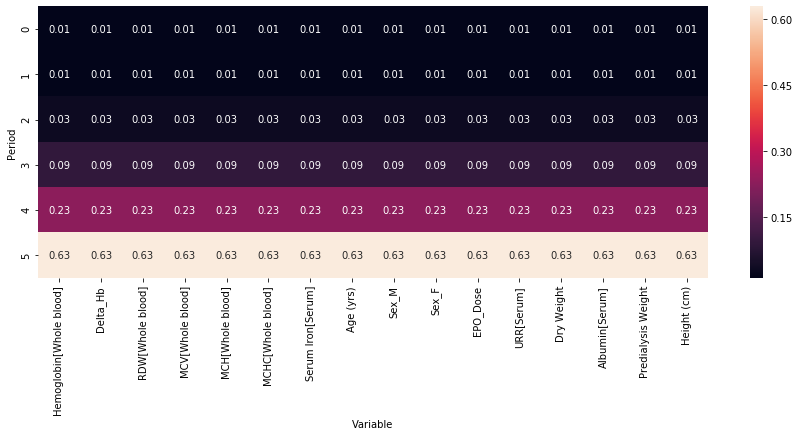

In [22]:
attention_model = Model(inputs=model.input, outputs=model.get_layer('attention_weight').output)   
attn2 = attention_model.predict(x_train)

import seaborn as sns
plt.figure(figsize=(15,5))
sns.heatmap((np.mean(np.repeat(attn2, repeats=len(trn_vars), axis=2), axis=0)).round(2), annot=True)
plt.xticks(np.array(range(len(trn_vars)))+0.5, trn_vars, rotation=90)
plt.xlabel('Variable')
plt.ylabel('Period')
plt.show()

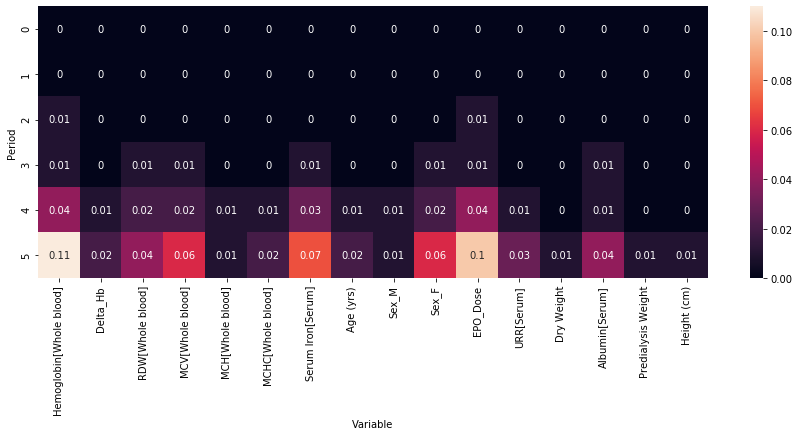

In [24]:
import seaborn as sns
plt.figure(figsize=(15,5))
sns.heatmap((np.mean(attn1*np.repeat(attn2, repeats=len(trn_vars), axis=2), axis=0)).round(2), annot=True)
plt.xticks(np.array(range(len(trn_vars)))+0.5, trn_vars, rotation=90)
plt.xlabel('Variable')
plt.ylabel('Period')
plt.show()

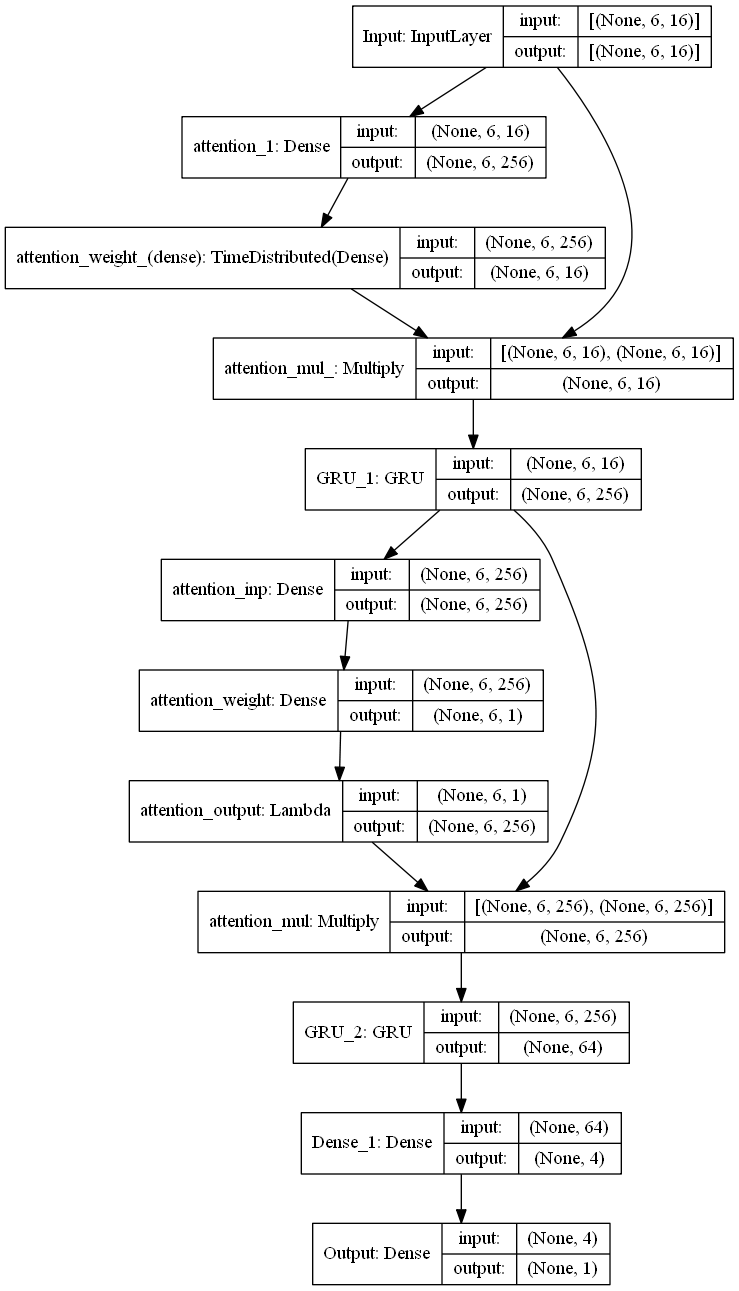

In [15]:
plot_model(model, show_shapes=True, show_layer_names=True)

# Performance by Hospital

In [6]:
seq_len = 6
learning_rate = 0.001
epochs = 100
batch_size = 2048 
seed = 0

def get_model():        
    K.clear_session()
    np.random.seed(seed)
    inp = Input(shape=(seq_len, len(trn_vars)))
    gauss1 = GaussianNoise(0.1)(inp)
    layer1 = GRU(256, return_sequences=True,
                recurrent_activation='hard_sigmoid',
                activation='tanh')(gauss1)
    layer2 = GRU(64, return_sequences=False,
                recurrent_activation='hard_sigmoid',
                activation='tanh')(layer1)   
    fc = Dense(4)(layer2)
    outp = Dense(1)(fc)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss = 'mean_absolute_error', 
                  optimizer=Adam(learning_rate),
                  metrics=['mean_absolute_error'])
    return model

model = get_model()
model.load_weights('./model/gru_mean_{}.h5'.format(seq_len))

In [38]:
with open('./data/mean_{}.pkl'.format(seq_len),'rb') as f:
    loaded_data = pickle.load(f)
[[x_train,y_train,train_info],[x_valid,y_valid,valid_info],[x_test,y_test,test_info]] = loaded_data

In [39]:
train_info = np.array([i[0] for i in train_info[:,0]])
valid_info = np.array([i[0] for i in valid_info[:,0]])
test_info = np.array([i[0] for i in test_info[:,0]])

In [45]:
for h in ['A', 'B', 'D', 'E', 'F', 'G', 'H']:
    print('Hospital:', h)
    
    pred_train = model.predict(x_train[train_info==h])
    print('train')
    pred_train = hb_scaler_mean.inverse_transform(pred_train)
    print('mae:', MAE(hb_scaler_mean.inverse_transform(y_train[train_info==h]), pred_train))

    pred_valid = model.predict(x_valid[valid_info==h])
    print('val')
    pred_valid = hb_scaler_mean.inverse_transform(pred_valid)
    print('mae:', MAE(hb_scaler_mean.inverse_transform(y_valid[valid_info==h]), pred_valid))

    pred_test = model.predict(x_test[test_info==h])
    print('test')
    pred_test = hb_scaler_mean.inverse_transform(pred_test)
    print('mae:', MAE(hb_scaler_mean.inverse_transform(y_test[test_info==h]), pred_test))

    print()
    print()    

Hospital: A
train
mae: 0.5523
val
mae: 0.6053
test
mae: 0.7004


Hospital: B
train
mae: 0.5198
val
mae: 0.5909
test
mae: 0.5964


Hospital: D
train
mae: 0.6036
val
mae: 0.8274
test
mae: 0.7812


Hospital: E
train
mae: 0.5907
val
mae: 0.6294
test
mae: 0.5709


Hospital: F
train
mae: 0.533
val
mae: 0.5606
test
mae: 0.5851


Hospital: G
train
mae: 0.5254
val
mae: 0.541
test
mae: 0.5708


Hospital: H
train
mae: 0.5679
val
mae: 0.5572
test
mae: 0.5999


